In [17]:
import pickle
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

from KNN_algorithm import KnnClassifier
from utilities_algorithms import get_xy,divide_into_correct_and_incorrect, draw_confusion_matrix, show_classified, kmeans, visualize_patches, plot_patches
from scipy.spatial import distance
from sklearn.metrics import accuracy_score, confusion_matrix

plt.set_cmap('gray')

<Figure size 432x288 with 0 Axes>

In [12]:
# load images
def load_images_from_folder(folder,color):
    images = {}
    for cdata in os.listdir(folder):
        # prevent to read something like .DS_store
        if cdata.startswith('.'):
            continue
        current_class = []
        path = folder + "/" + cdata
        for file in os.listdir(path):
            # prevent to read something like .DS_store
            if file.startswith('.'):
                continue
            image = cv2.imread(path + "/" + file)
            if color == 'gray':
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if image is not None:
                current_class.append(image)
        images[cdata] = current_class
    return images


# Read from directory
train_set  = load_images_from_folder('COMP338_Assignment1_Dataset/Training',color='gray')
test_set = load_images_from_folder('COMP338_Assignment1_Dataset/Test',color='gray')
test_set_rgb = load_images_from_folder('COMP338_Assignment1_Dataset/Test',color='rgb')

In [13]:
# load descriptors by class
with open('Models/SIFT_feature/train_descriptors_by_class.pkl', 'rb') as f:
    train_des_by_class  = pickle.load(f)

# load key_points by class
with open('Models/SIFT_feature/train_keypoint_by_class.pkl', 'rb') as f:
    train_kp_by_class = pickle.load(f)

# load .pkl file of all descriptors
with open('Models/SIFT_feature/all_training_descriptors.pkl', 'rb') as f:
    train_des_list = pickle.load(f)

# load histogram of SIFT feature for training and test set
with open('Models/histograms/train_histogram.pkl', 'rb') as f:
    train_histogram = pickle.load(f)

with open('Models/histograms/test_histogram.pkl', 'rb') as f:
    test_histogram = pickle.load(f)

# load descriptors by class for test set
with open('Models/SIFT_feature/test_descriptors_by_class.pkl', 'rb') as f:
    test_des_by_class  = pickle.load(f)

## Step 7: Replace 500 code words with the 20 code words

### Generate Code Words

In [52]:
words_small = kmeans(20, train_des_list)

### Generate Histogram

In [53]:
def find_index(features, center):
    count = 0
    ind = 0
    for i in range(len(center)):
        if i == 0:
            count = distance.euclidean(features, center[i])
        else:
            dist = distance.euclidean(features, center[i])
            if dist < count:
                ind = i
                count = dist
    return ind


def image_histogram(all_words, centers):
    dict_feature = {}
    for image_class, folder in all_words.items():
        category = []
        pbar = tqdm(folder, position=0)
        for image in pbar:
            pbar.set_description(f"Process {image_class} images")
            histogram = np.zeros(len(centers))
            for each_feature in image:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            # normalize
            histogram = histogram/sum(histogram)
            category.append(histogram)
        dict_feature[image_class] = category
    return dict_feature

In [54]:
print(' #### Generate histogram from training descriptors and 20 code words ####')
train_histogram_small = image_histogram(train_des_by_class, words_small)
print(' #### Generate histogram from testing descriptors and 20 code words ####')
test_histogram_small = image_histogram(test_des_by_class, words_small)

 #### Generate histogram from training descriptors and 20 code words ####


Process keyboard images: 100%|██████████| 70/70 [00:01<00:00, 63.70it/s]


 #### Generate histogram from testing descriptors and 20 code words ####


Process keyboard images: 100%|██████████| 10/10 [00:00<00:00, 63.78it/s]


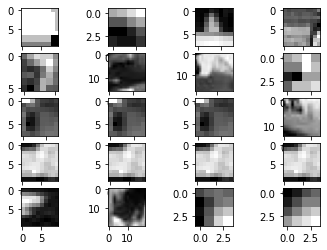

In [55]:
image_patches_small = visualize_patches(train_des_by_class, train_kp_by_class, words_small, 20, dataset=train_set)
plot_patches(image_patches_small)

In [56]:
train_x_small, train_y_small = get_xy(train_histogram_small)
test_x_small, test_y_small = get_xy(test_histogram_small)
l2_knn_small = KnnClassifier(k=1, dis_type='L2')
l2_knn_small.fit(train_x_small, train_y_small)
predict_y_l2_small = l2_knn_small.predict(test_x_small)
correct_l2_small, incorrect_l2_small = divide_into_correct_and_incorrect(list(test_set.keys()),test_y_small, predict_y_l2_small)

print('--------------------------------------')
l2_score_small = accuracy_score(test_y_small, predict_y_l2_small)
print(f"The average of predication based on L2 KNN and 20 code words for all classes is {l2_score_small}")
for key, value in correct_l2_small.items():
    print(f"The average of predication based on L2 KNN and 20 code words for class {key} is {len(value)/len(test_set[key])}")

--------------------------------------
The average of predication based on L2 KNN and 20 code words for all classes is 0.32
The average of predication based on L2 KNN and 20 code words for class airplanes is 0.2
The average of predication based on L2 KNN and 20 code words for class dog is 0.2
The average of predication based on L2 KNN and 20 code words for class cars is 0.7
The average of predication based on L2 KNN and 20 code words for class faces is 0.3
The average of predication based on L2 KNN and 20 code words for class keyboard is 0.2


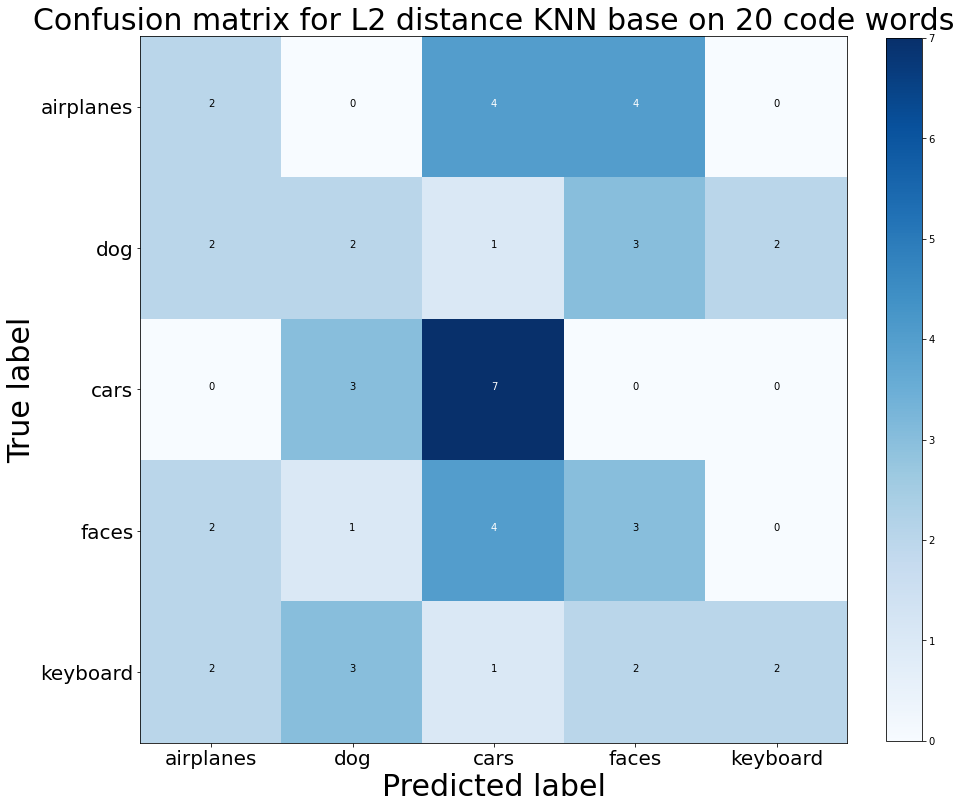

In [57]:
# Calculate Confusion matrix
cm_l2_small = confusion_matrix(test_y_small, predict_y_l2_small, labels=list(test_histogram_small.keys()))
draw_confusion_matrix(cm_l2_small, 'Confusion matrix for L2 distance KNN base on 20 code words', list(test_histogram_small.keys()))

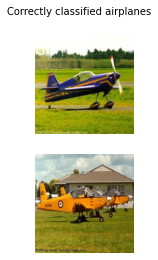

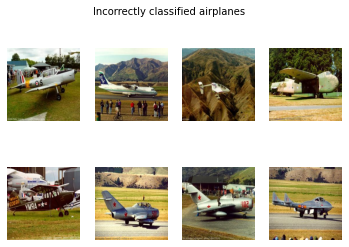

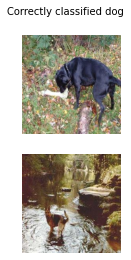

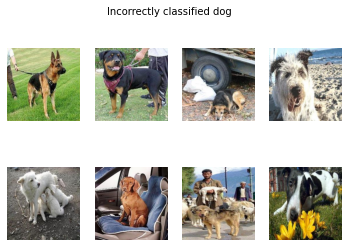

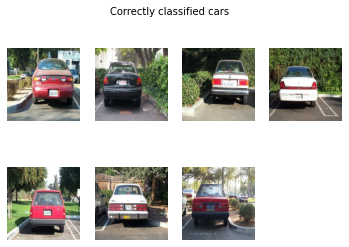

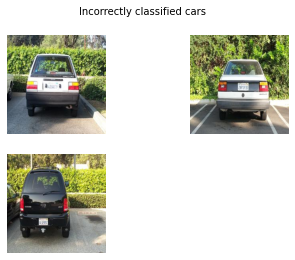

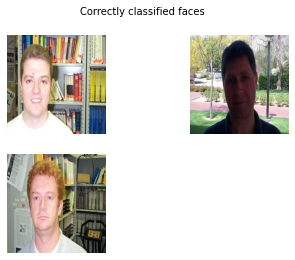

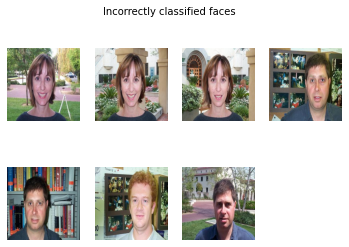

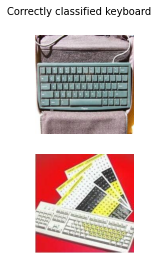

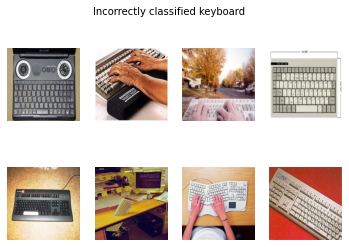

In [58]:
show_classified(test_set_rgb, correct_l2_small, incorrect_l2_small)